In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import torchaudio.transforms as T

from Model import iESPnet
from scipy import fft as sp_fft
from scipy import stats
import librosa

FREQ_MASK_PARAM = 10
TIME_MASK_PARAN = 20
N_CLASSES = 1
learning_rate = 1e-3
batch_size = 128
epochs = 20
num_workers = 4

top_db = 40.0

### Model Definition

In [4]:
hparams = {
        "n_cnn_layers": 3,
    "n_rnn_layers": 3,
    "rnn_dim": [150, 100, 50],
    "n_class": N_CLASSES,
    "out_ch": [8,8,16],
    "dropout": 0.3,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "num_workers": num_workers,
    "epochs": epochs
}
model = iESPnet(hparams['n_cnn_layers'],
                       hparams['n_rnn_layers'],
                       hparams['rnn_dim'],
                       hparams['n_class'],
                       hparams['out_ch'],
                       hparams['dropout'],
                       )

checkpoint = torch.load(
    r"X:\Users\timon\Paper_iESPnet\Results\PIT-RNS9536\models\model_opt.pth",
    map_location=torch.device('cpu')
)

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Example Inference using .npy example spectrogram

In [12]:
example_batch = r"Data\PIT_RNS9536_20170927-1_E6.npy"
dat_np = np.load(example_batch, allow_pickle=True)
dat_np_arr = dat_np.item()["spectrogram"]

dat_np_arr = np.expand_dims(dat_np_arr, axis=0)  # Shape for batch inference

In [14]:
dat_np_arr.shape

(1, 4, 120, 181)

Text(0.5, 1.0, 'Input Spectrogram')

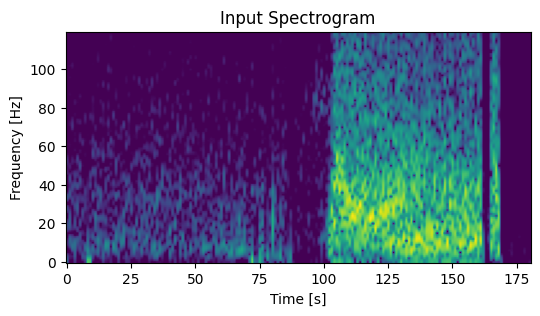

In [13]:
plt.figure(figsize=(6, 3))
plt.imshow(dat_np_arr[0, 0, :, : ], aspect="auto")
plt.gca().invert_yaxis()
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Input Spectrogram")

In [15]:
model.to(torch.device('cpu'))
model = model.float()
model.eval()
with torch.no_grad():
    dat_np_arr = dat_np_arr.astype(np.double)
    x = torch.from_numpy(dat_np_arr)
    outputs = model(x.float())

    m = nn.Sigmoid()

    probs = m(outputs)

Text(0, 0.5, 'Probability')

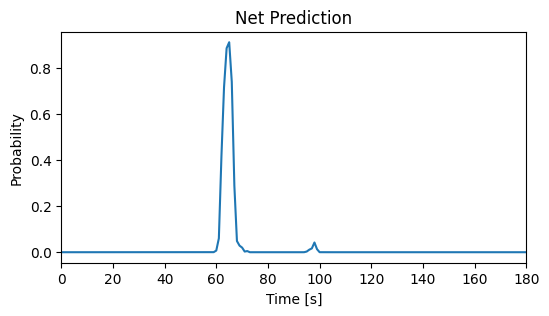

In [17]:
plt.figure(figsize=(6, 3))
plt.plot(probs)
plt.xlabel("Time [s]")
plt.xlim(0, 180)
plt.title("Net Prediction")
plt.ylabel("Probability")

### Inference based on a time series

In [19]:
DAT_File_Example = r"Z:\RNS_data\ecog_reconstructed\MGH\RNS0259\131589812123970000.dat"

b = open(DAT_File_Example, "rb").read()
ecog = np.frombuffer(b, dtype=np.int16)
ecog = ecog - 512
ecog = ecog.reshape([-1, 4])

n_fft = 256
fs = 250
TT = 1000 # window length
overlap = 500
win_len = int(fs * TT / 1000 ) # win size
hop_len = int(fs * (TT - overlap) / 1000)   # Length of hop between windows.
power = 2.0

wind_dic={
    'periodic':True,
    'beta':10
}
            
spectrogram = T.Spectrogram(n_fft=n_fft, win_length=win_len,
                            hop_length=hop_len, pad=0,
                            window_fn =torch.kaiser_window,
                            normalized=False,
                            power=power, wkwargs=wind_dic)

signal = stats.zscore(ecog)


time = np.arange(win_len/2, signal.shape[-1] + win_len/2 + 1,
                    win_len - (win_len-hop_len))/float(fs)
time -= (win_len/2) / float(fs)
freqs = sp_fft.rfftfreq(n_fft, 1/fs)
out_ = spectrogram(torch.from_numpy(signal.T))

spec = librosa.power_to_db(out_, top_db=top_db)
# save up to 60 Hz
idx_60 = np.where(freqs<= 60)[0][-1]
spec = spec[:, :idx_60,:]

### Run Inference

In [20]:
dat_np_arr = np.expand_dims(spec, axis=0)

model.to(torch.device('cpu'))
model = model.float()
model.eval()
with torch.no_grad():
    dat_np_arr = dat_np_arr.astype(np.double)
    x = torch.from_numpy(dat_np_arr)
    outputs = model(x.float())

    m = nn.Sigmoid()

    probs = m(outputs)

Text(0, 0.5, 'Probability')

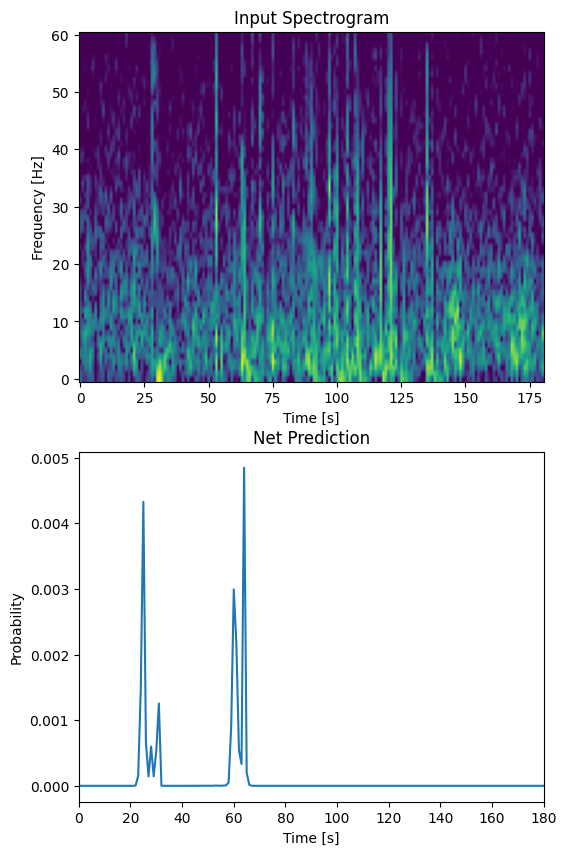

In [21]:
plt.figure(figsize=(6, 10))
plt.subplot(211)
plt.imshow(spec[0, :, : ], aspect="auto")
plt.gca().invert_yaxis()
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Input Spectrogram")
plt.subplot(212)
plt.plot(probs)
plt.xlabel("Time [s]")
plt.xlim(0, 180)
plt.title("Net Prediction")
plt.ylabel("Probability")